In [1]:
import os.path
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import yt
import glob
import pandas as pd
import math
import scipy.integrate as integrate
from matplotlib.backends.backend_pdf import PdfPages
mpl.rcParams['figure.dpi'] = 300

/home/dbeckers/.conda/envs/postprocessing/lib/python3.7/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]


In [31]:
def tophat(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 0.5 * width):
        return amplitude
    else:
        return 0.0

In [3]:
def gaussian(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return amplitude * math.exp( - ((x - convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [4]:
def yalla2021(x,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs((x-convected_distance) - center) < 6 * width):
        return math.cos(eta * (x-convected_distance)) * amplitude * math.exp( - ((x-convected_distance) - center) ** 2 / (2 * width ** 2))
    else:
        return 0.0

In [164]:
def tophatfv(func,x,dx,center,amplitude,width,eta,t):
    convected_distance = 1.0 * t # assumes unit convection velocity
    if (abs(abs((x-convected_distance) - center) - width / 2) < dx / 2) :
        return amplitude * (width / 2 - abs((x-convected_distance) - center) + dx / 2) / dx
    elif (abs((x-convected_distance) - center) < width / 2) :
        return amplitude
    else :
        return 0.0

In [169]:
center = 0.25
amplitude = 1.0
# width = 0.0251646060
width = 0.05
eta = 226.1946710304
t_final = 0.5
Lx = 1.0
function = tophat

In [170]:
def natural_sort(l):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split("([0-9]+)", key)]
    return sorted(l, key=alphanum_key)

In [171]:
def exact_sol_cell_average_scipy(func,x,dx,center,amplitude,width,eta,t) :
    integral = integrate.quad(func,x-dx/2,x+dx/2,args=(center,amplitude,width,eta,t))
    return integral[0]/dx

In [172]:
def exact_sol_cell_average_GLQ(func,x,dx,center,amplitude,width,eta,t) :
    w_i = [0.5555555556, 0.8888888889, 0.5555555556]
    dx_i = [-0.7745966692, 0, 0.7745966692]
    s = 0.0
    for i in range(len(w_i)) :
        s += w_i[i] * func(x + dx_i[i]*dx/2, center, amplitude, width, eta, t)
    return s/2

In [173]:
def zero_dist_error(func,x_dist,dx_dist,initial_center,amplitude,width,eta,t_dist) :
    scalar_dist = np.zeros(len(x_dist))
    errors = np.zeros(len(t_dist))
    for i in range(len(t_dist)) :
        errors[i] = L2_error(func,x_dist,scalar_dist,dx_dist,initial_center,amplitude,width,eta,t_dist[i])
    return errors

In [174]:
def error_dist(func,x_dist,scalar_dist,dx_dist,initial_center,amplitude,width,eta,t) :
    error_dist = [abs(scalar_dist[i] - tophatfv(func,x_dist[i],dx_dist[i],initial_center,amplitude,width,eta,t)) for i in range(len(x_dist))]
    return error_dist

In [175]:
def L2_error(func,x_dist,scalar_dist,dx_dist,initial_center,amplitude,width,eta,t) :
    ed = error_dist(func,x_dist,scalar_dist,dx_dist,initial_center,amplitude,width,eta,t)
    L2_error = math.sqrt(sum([dx_dist[i] * ed[i] ** 2 for i in range(len(ed))]))
    return L2_error

In [176]:
root_dir = '/home/dbeckers/tests/scalar_advection'

In [182]:
# methods = ['godunov_ppm','godunov_weno_z','mol_central_CFL_0.5']
methods = ['godunov_ppm']
# methods = ['godunov_weno_z']
# methods = ['mol_central_CFL_0.45']
# methods = ['godunov_ppm','godunov_weno_z']
# methods = ['mol_central','periodic_mol_central']


# case = 'yalla2021/eta_2'
case = 'tophat'
# grid_types = ['uniform','fine_to_coarse']
# grid_types = ['fine_to_coarse']
grid_types = ['uniform']
grid_sizes = [64*2**i for i in range(3)]
dx_list = [Lx/grid_size for grid_size in grid_sizes]
print(grid_sizes)
color_list = [
    "#EE2E2F",
    "#008C48",
    "#185AA9",
    "#F47D23",
    "#662C91",
    "#A21D21",
    "#B43894",
    "#010202",
]
linestyle_list = [
    "solid",
    "dashed",
    "dotted",
    "dashdot"
]
linewidth_list = [
    1.5,
    0.5
]

[64, 128, 256]


In [183]:
idx = -1
fields = ["x","temperature"]

In [184]:
%%capture
fig1, ax1 = plt.subplots(figsize=(14, 6))
fig2, ax2 = plt.subplots(figsize=(14, 10))
fig3, ax3 = plt.subplots(figsize=(14, 10))
fig4, ax4 = plt.subplots(figsize=(14, 10))

error_lists = [[[] for i in range(len(grid_types))] for j in range(len(methods))]

k = -1
for method in methods:
    k += 1
    g = -1
    for grid_type in grid_types:
        g += 1
        l = -1
        for grid_size in grid_sizes:
            l += 1
            case_dir = os.path.join(root_dir, method, case, grid_type, f'nx_{grid_size}')
            
            # Load plt files
            plt_files = natural_sort(glob.glob(os.path.join(case_dir, "plt*")))
            ds = yt.load(plt_files[idx])
            ray = ds.ortho_ray(0, (0, 0))
            srt = np.argsort(ray["x"])
            df = pd.DataFrame({f: np.array(ray[f][srt]) for f in fields})
            t = ds.current_time.value.flatten()[0]
            df["time"] = t
            df["dx"] = [ray.fwidth[i][0].value.flatten()[0] for i in range(len(df["x"].values))]
            
            # Plot error
            error_file = os.path.join(case_dir,'error.log')
            with open(error_file) as f:
                lines = f.readlines()
                error_levels = len(lines[1].split())-1
                time = [float(line.split()[0]) for line in lines]
                for level in range(error_levels):
                    error = [float(line.split()[level+1]) for line in lines]
                    ax1.plot(time, error, color=color_list[l], linestyle=linestyle_list[k], linewidth=linewidth_list[g],label=f'{method}; nx = {grid_size}; grid type = {grid_type}; level {level}')
            
#             # Plot zero distribution error (only once)
#             if k == 0 :
#                 t_zde = np.linspace(0, t_final, num=int(500/(l+1)))
#                 zde = zero_dist_error(df["x"].values,df["dx"],center,amplitude,width,eta,t_zde)
#                 ax1.plot(t_zde, zde, color=color_list[l], linewidth=0.5, linestyle=linestyle_list[0])
            
            # Plot scalar distribution
            ax2.plot(df["x"].values, df["temperature"].values, color=color_list[l], label=f'{method}; nx = {grid_size}; grid type = {grid_type}; t = {t}', linewidth=linewidth_list[g], linestyle=linestyle_list[k])
            
            # Plot error distribution
            ed = error_dist(function,df["x"].values,df["temperature"].values,df["dx"].values,center,amplitude,width,eta,t)
            ax3.plot(df["x"].values, ed, label=f'{method}; grid type = {grid_type}; nx = {grid_size}; t = {t}', color=color_list[l], linewidth=linewidth_list[g], linestyle=linestyle_list[k])
            
            # Plot error marker on fig 1
            L2e = L2_error(function,df["x"].values,df["temperature"].values,df["dx"].values,center,amplitude,width,eta,t)
            ax1.plot([t], [L2e], marker='o', markersize=3, color='black')
            
            # Add error to list for log-log plot
            error_lists[k][g].append(L2e)
            
        ax4.plot(dx_list,error_lists[k][g],linestyle=linestyle_list[k],linewidth=linewidth_list[g],color='black',label=f'{method}; grid type = {grid_type}')


x_exact = np.linspace(0, 1, num=10000)
scalar_exact = [function(xi,center,amplitude,width,eta,t) for xi in x_exact]
ax2.plot(x_exact, scalar_exact, label = f'exact solution; t = {t}', color="black", linestyle="dashed", linewidth=0.5)

ax4.plot(dx_list,[1e4*dx**2 for dx in dx_list],label='dx^2')
ax4.plot(dx_list,[1e6*dx**3 for dx in dx_list],label='dx^3')
ax4.plot(dx_list,[1e8*dx**4 for dx in dx_list],label='dx^4')


yt : [INFO     ] 2022-07-31 16:55:19,359 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-07-31 16:55:19,365 Parameters: domain_dimensions         = [64  4  4]
yt : [INFO     ] 2022-07-31 16:55:19,366 Parameters: domain_left_edge          = [ 0.      -0.03125 -0.03125]
yt : [INFO     ] 2022-07-31 16:55:19,367 Parameters: domain_right_edge         = [1.      0.03125 0.03125]
yt : [INFO     ] 2022-07-31 16:55:20,743 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-07-31 16:55:20,764 Parameters: domain_dimensions         = [128   4   4]
yt : [INFO     ] 2022-07-31 16:55:20,765 Parameters: domain_left_edge          = [ 0.       -0.015625 -0.015625]
yt : [INFO     ] 2022-07-31 16:55:20,766 Parameters: domain_right_edge         = [1.       0.015625 0.015625]
yt : [INFO     ] 2022-07-31 16:55:22,048 Parameters: current_time              = 0.5
yt : [INFO     ] 2022-07-31 16:55:22,052 Parameters: domain_dimensions         = [256   4   4]
yt : [INFO     ] 2022-0

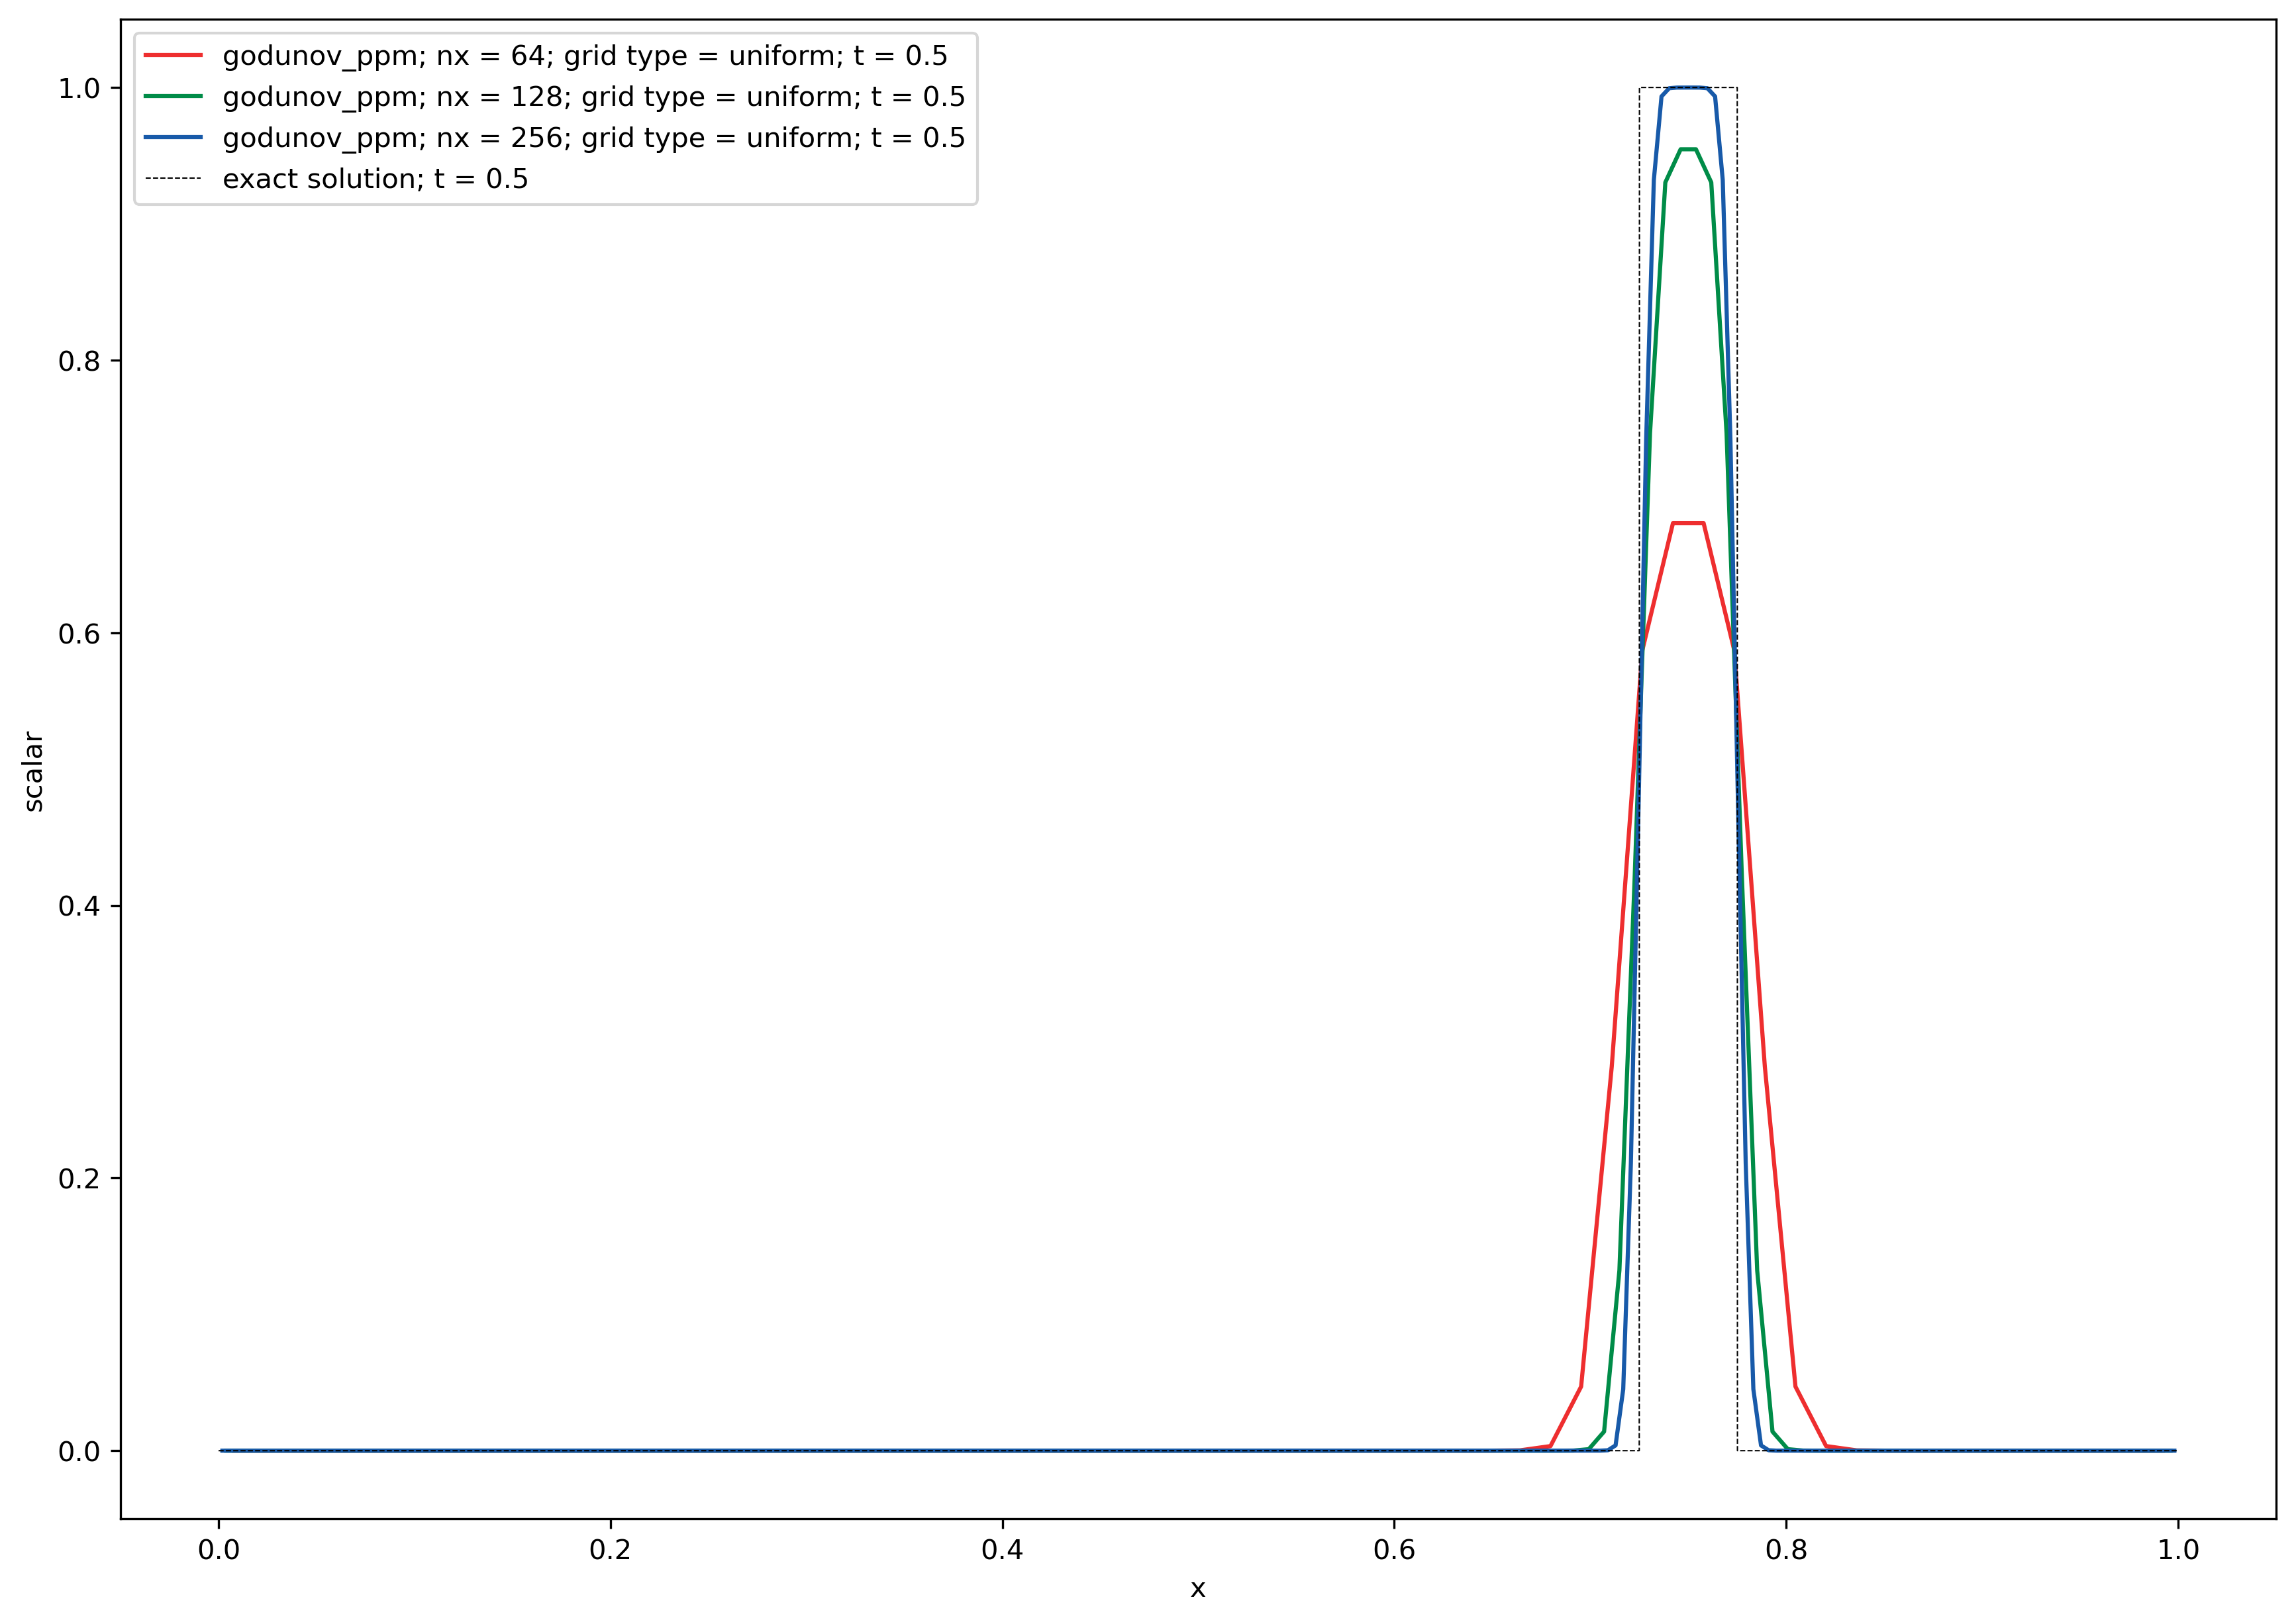

In [185]:
ax2.set_xlabel('x')
ax2.set_ylabel('scalar')
ax2.set_title('')
ax2.legend()
fig2

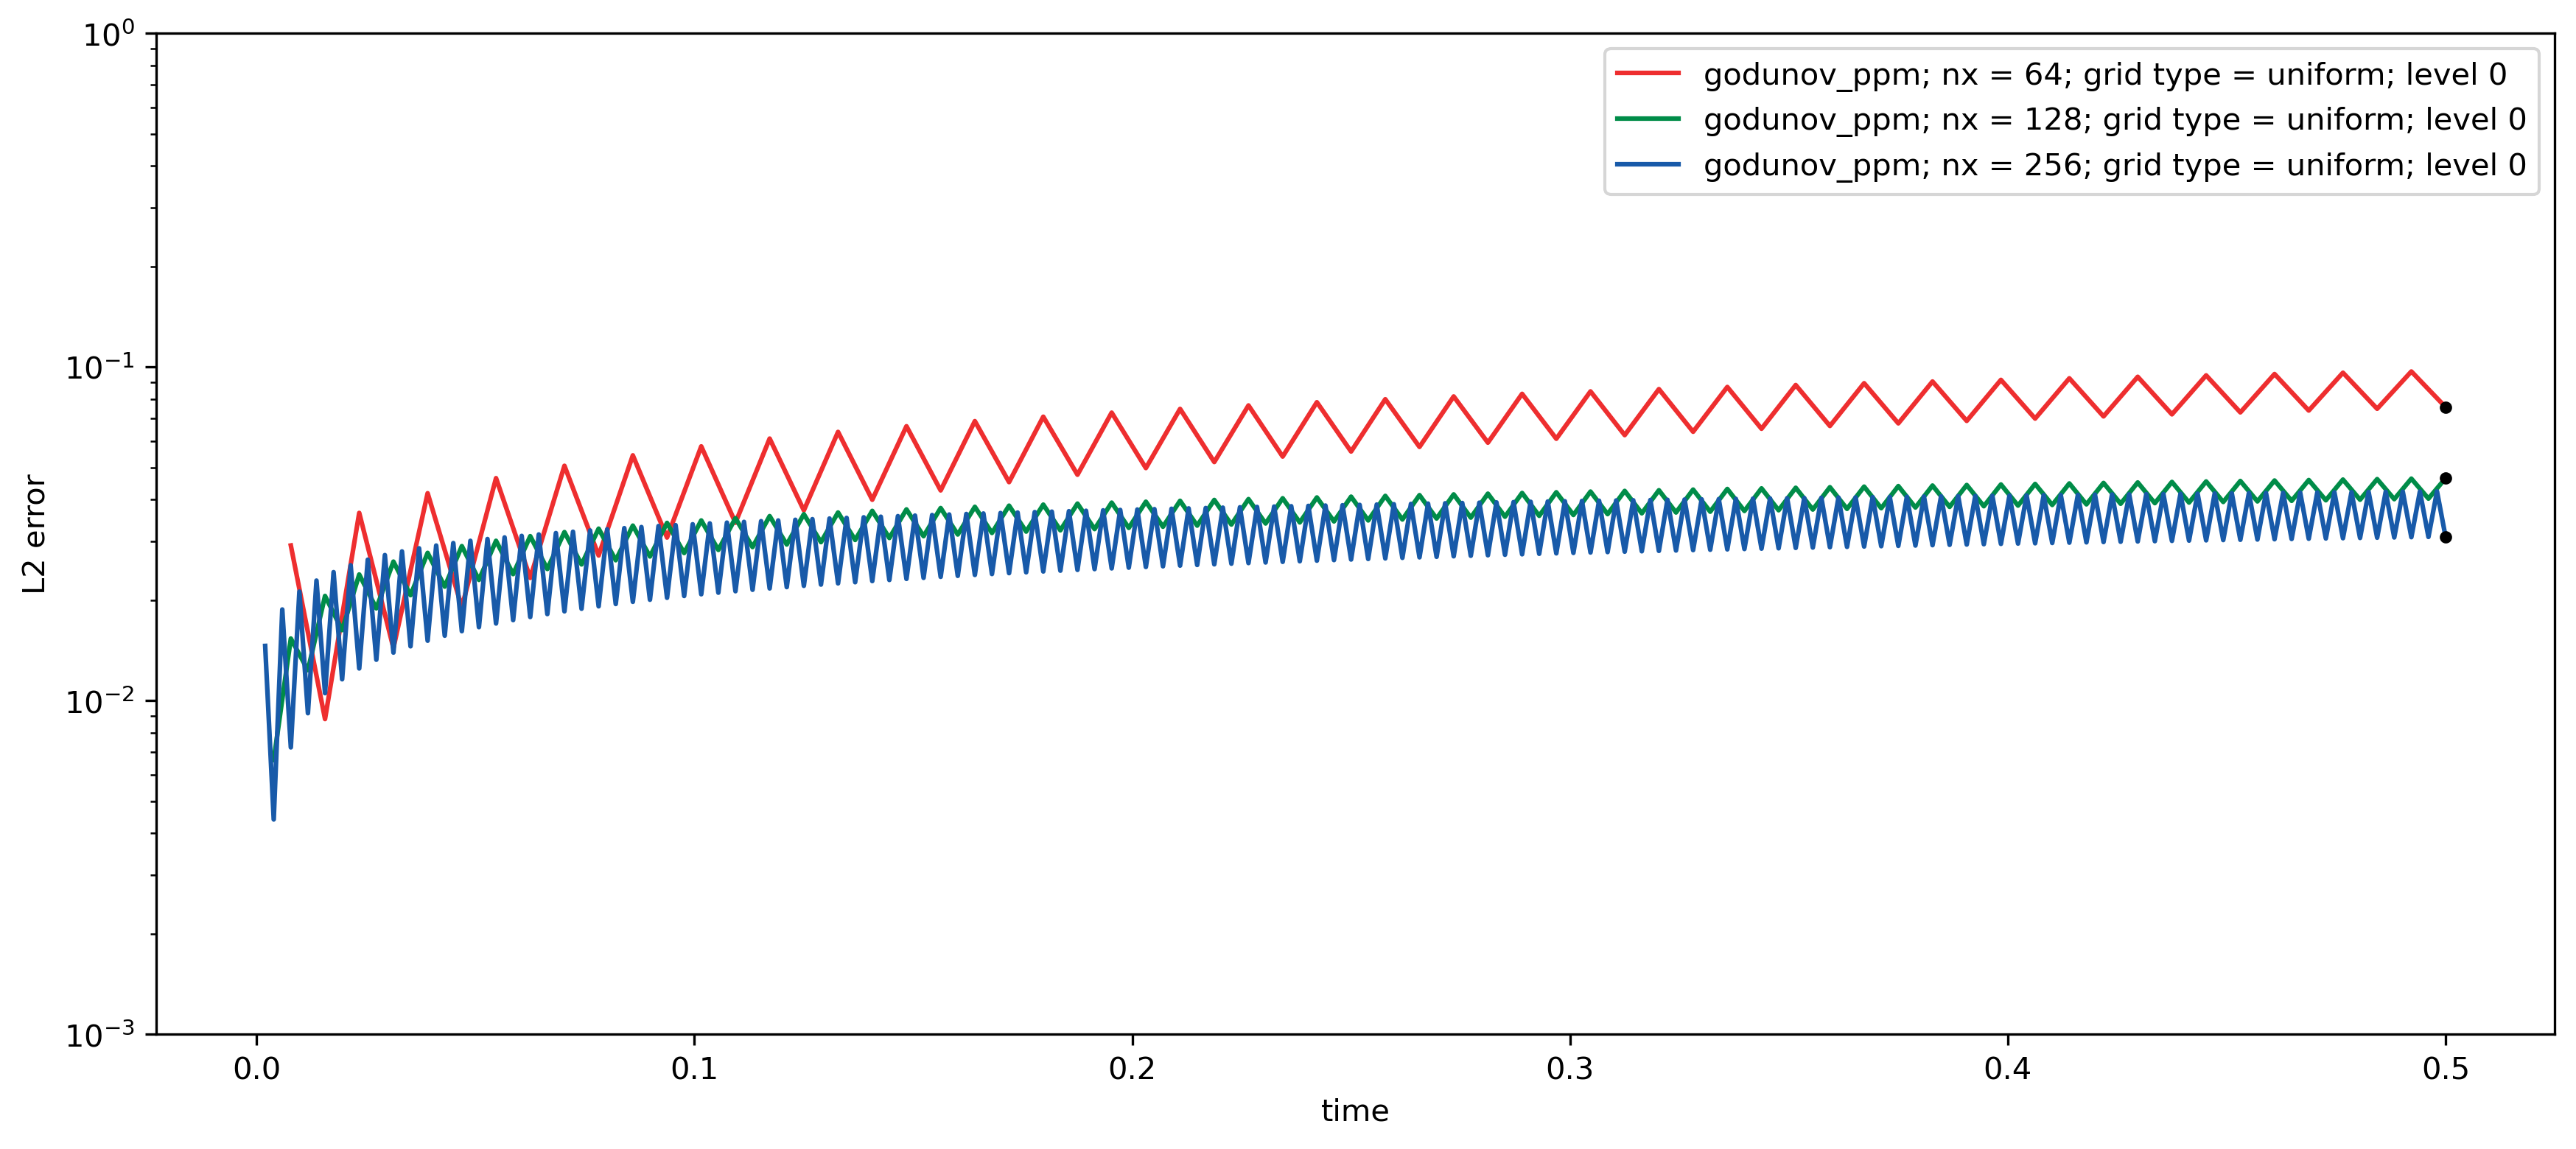

In [186]:
ax1.set_xlabel('time')
ax1.set_ylabel('L2 error')
ax1.set_title('')
ax1.legend()
ax1.set_yscale('log')
ax1.set_ylim([1e-3,1])
fig1

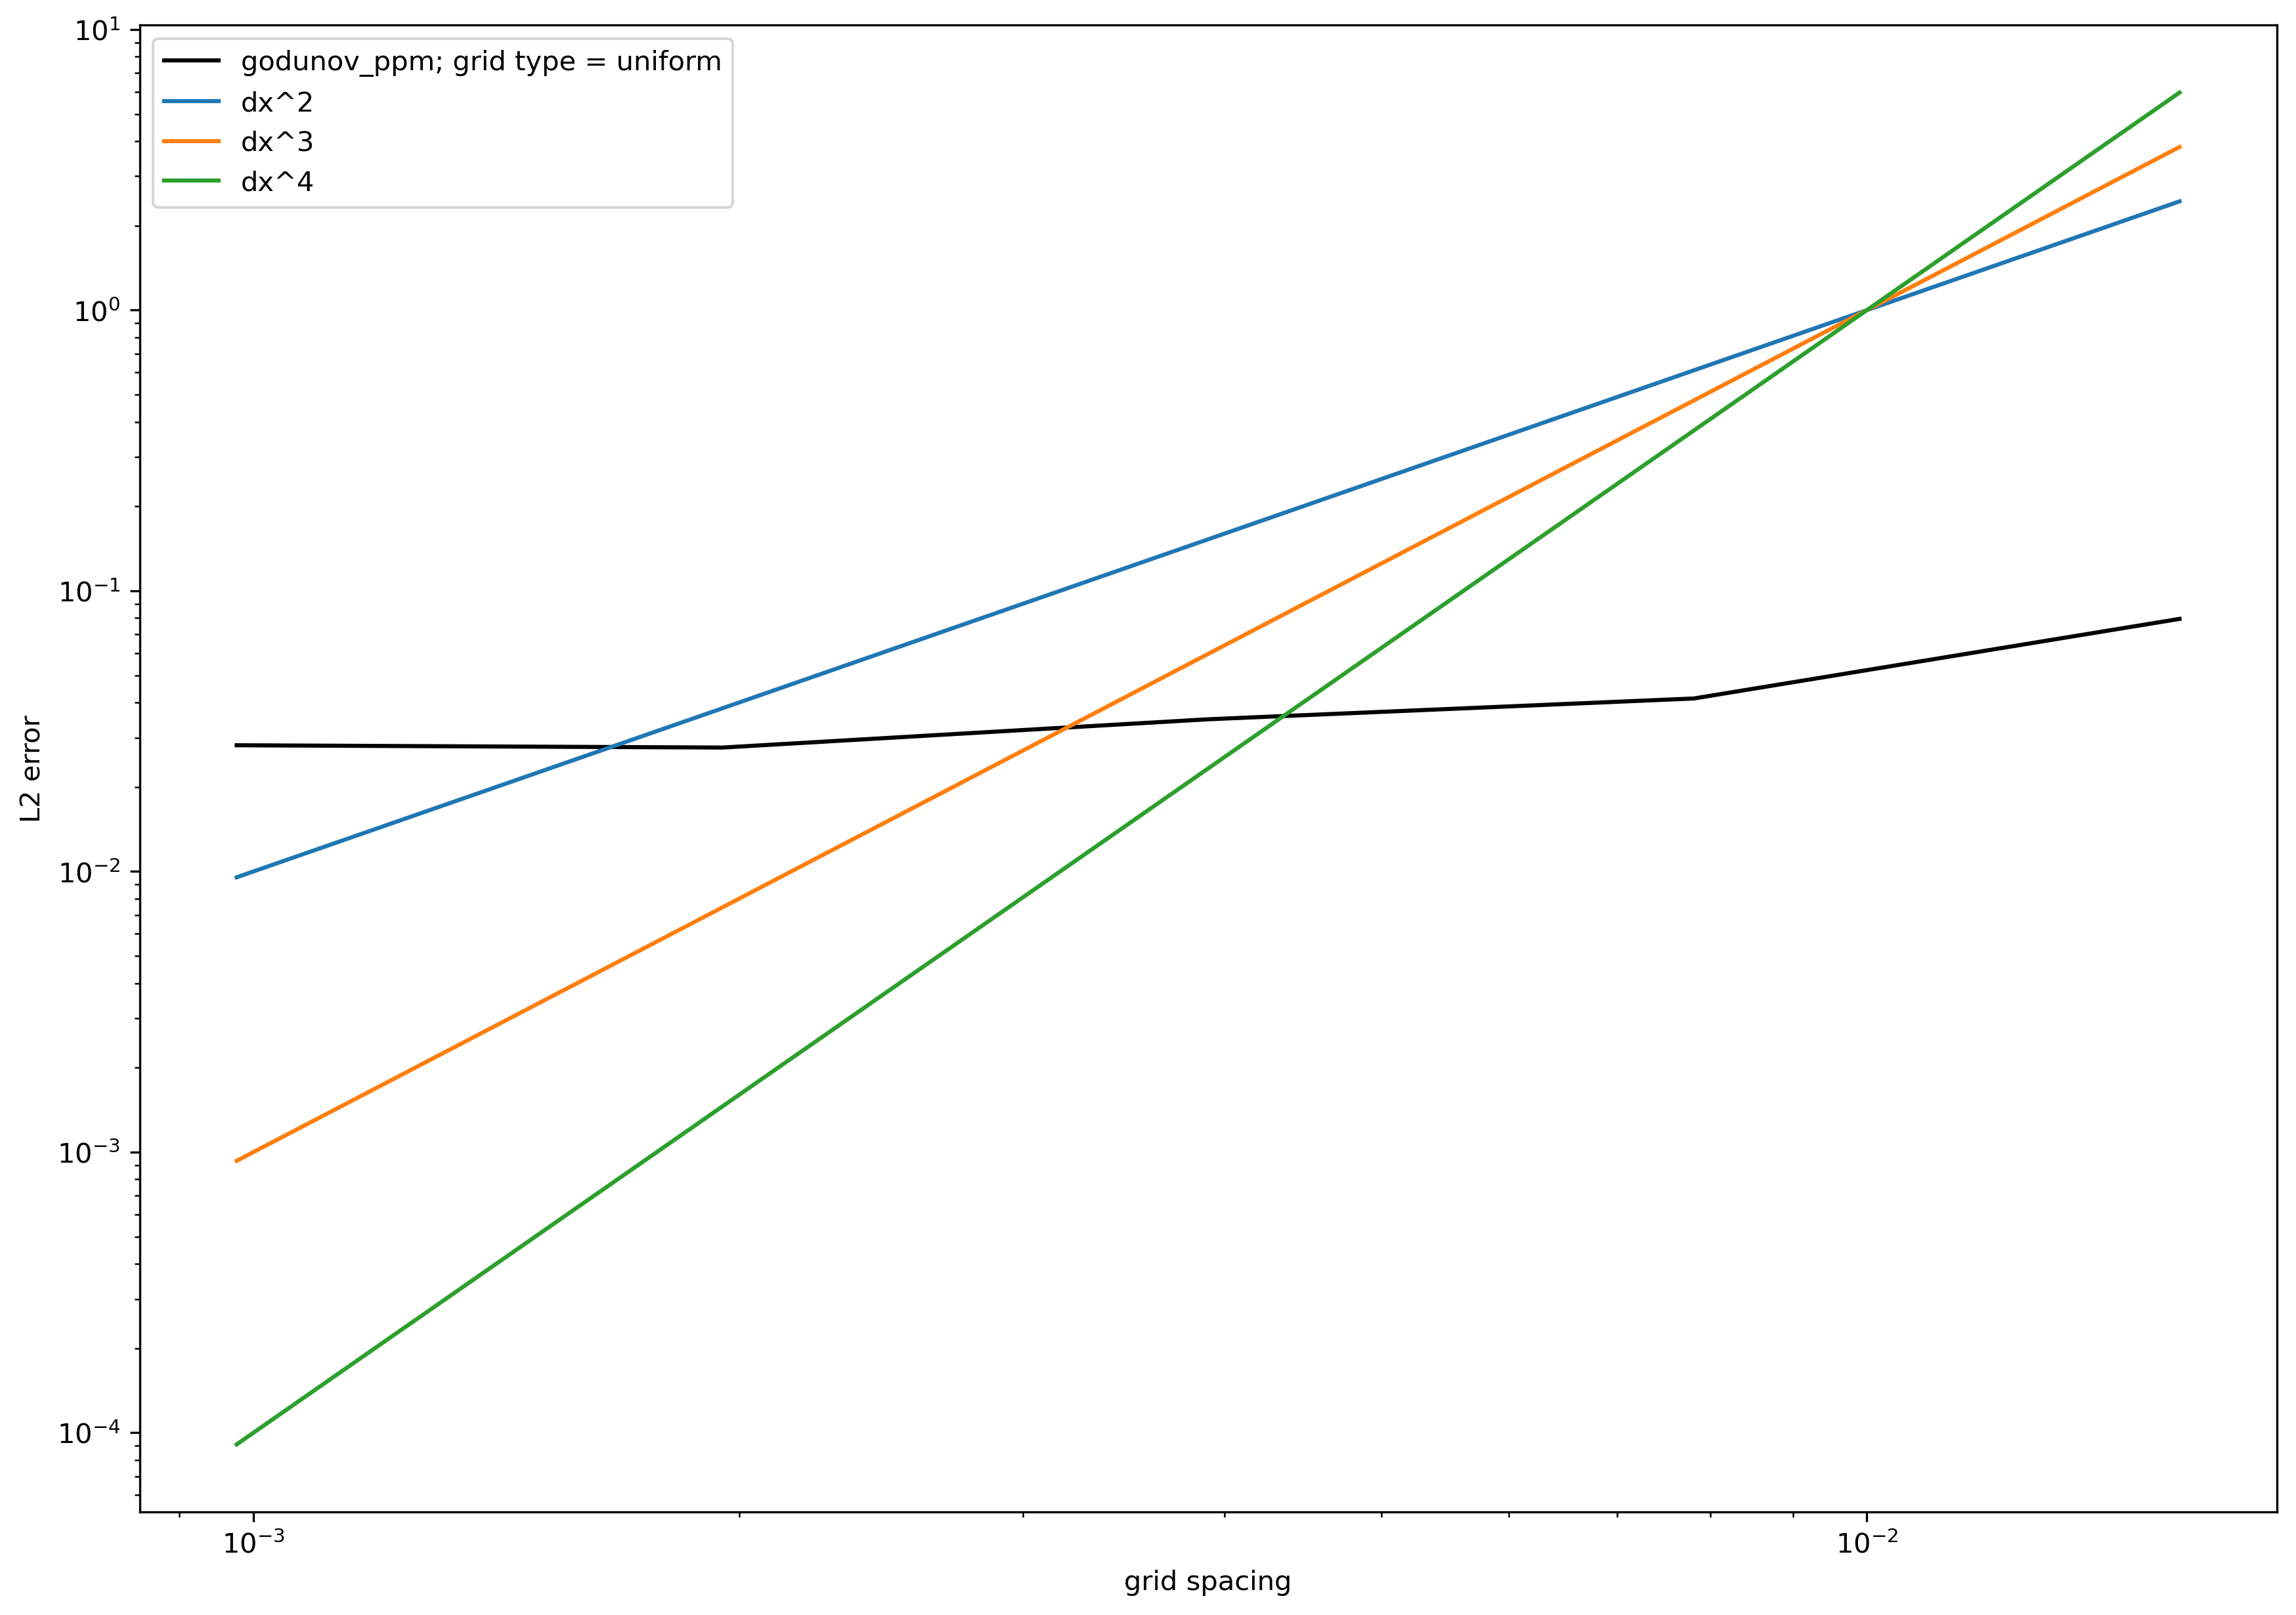

In [141]:
ax4.set_xlabel('grid spacing')
ax4.set_ylabel('L2 error')
ax4.set_title('')
ax4.set_yscale('log')
ax4.set_xscale('log')
ax4.legend()

# ax4.set_ylim([1e-4,1])
fig4

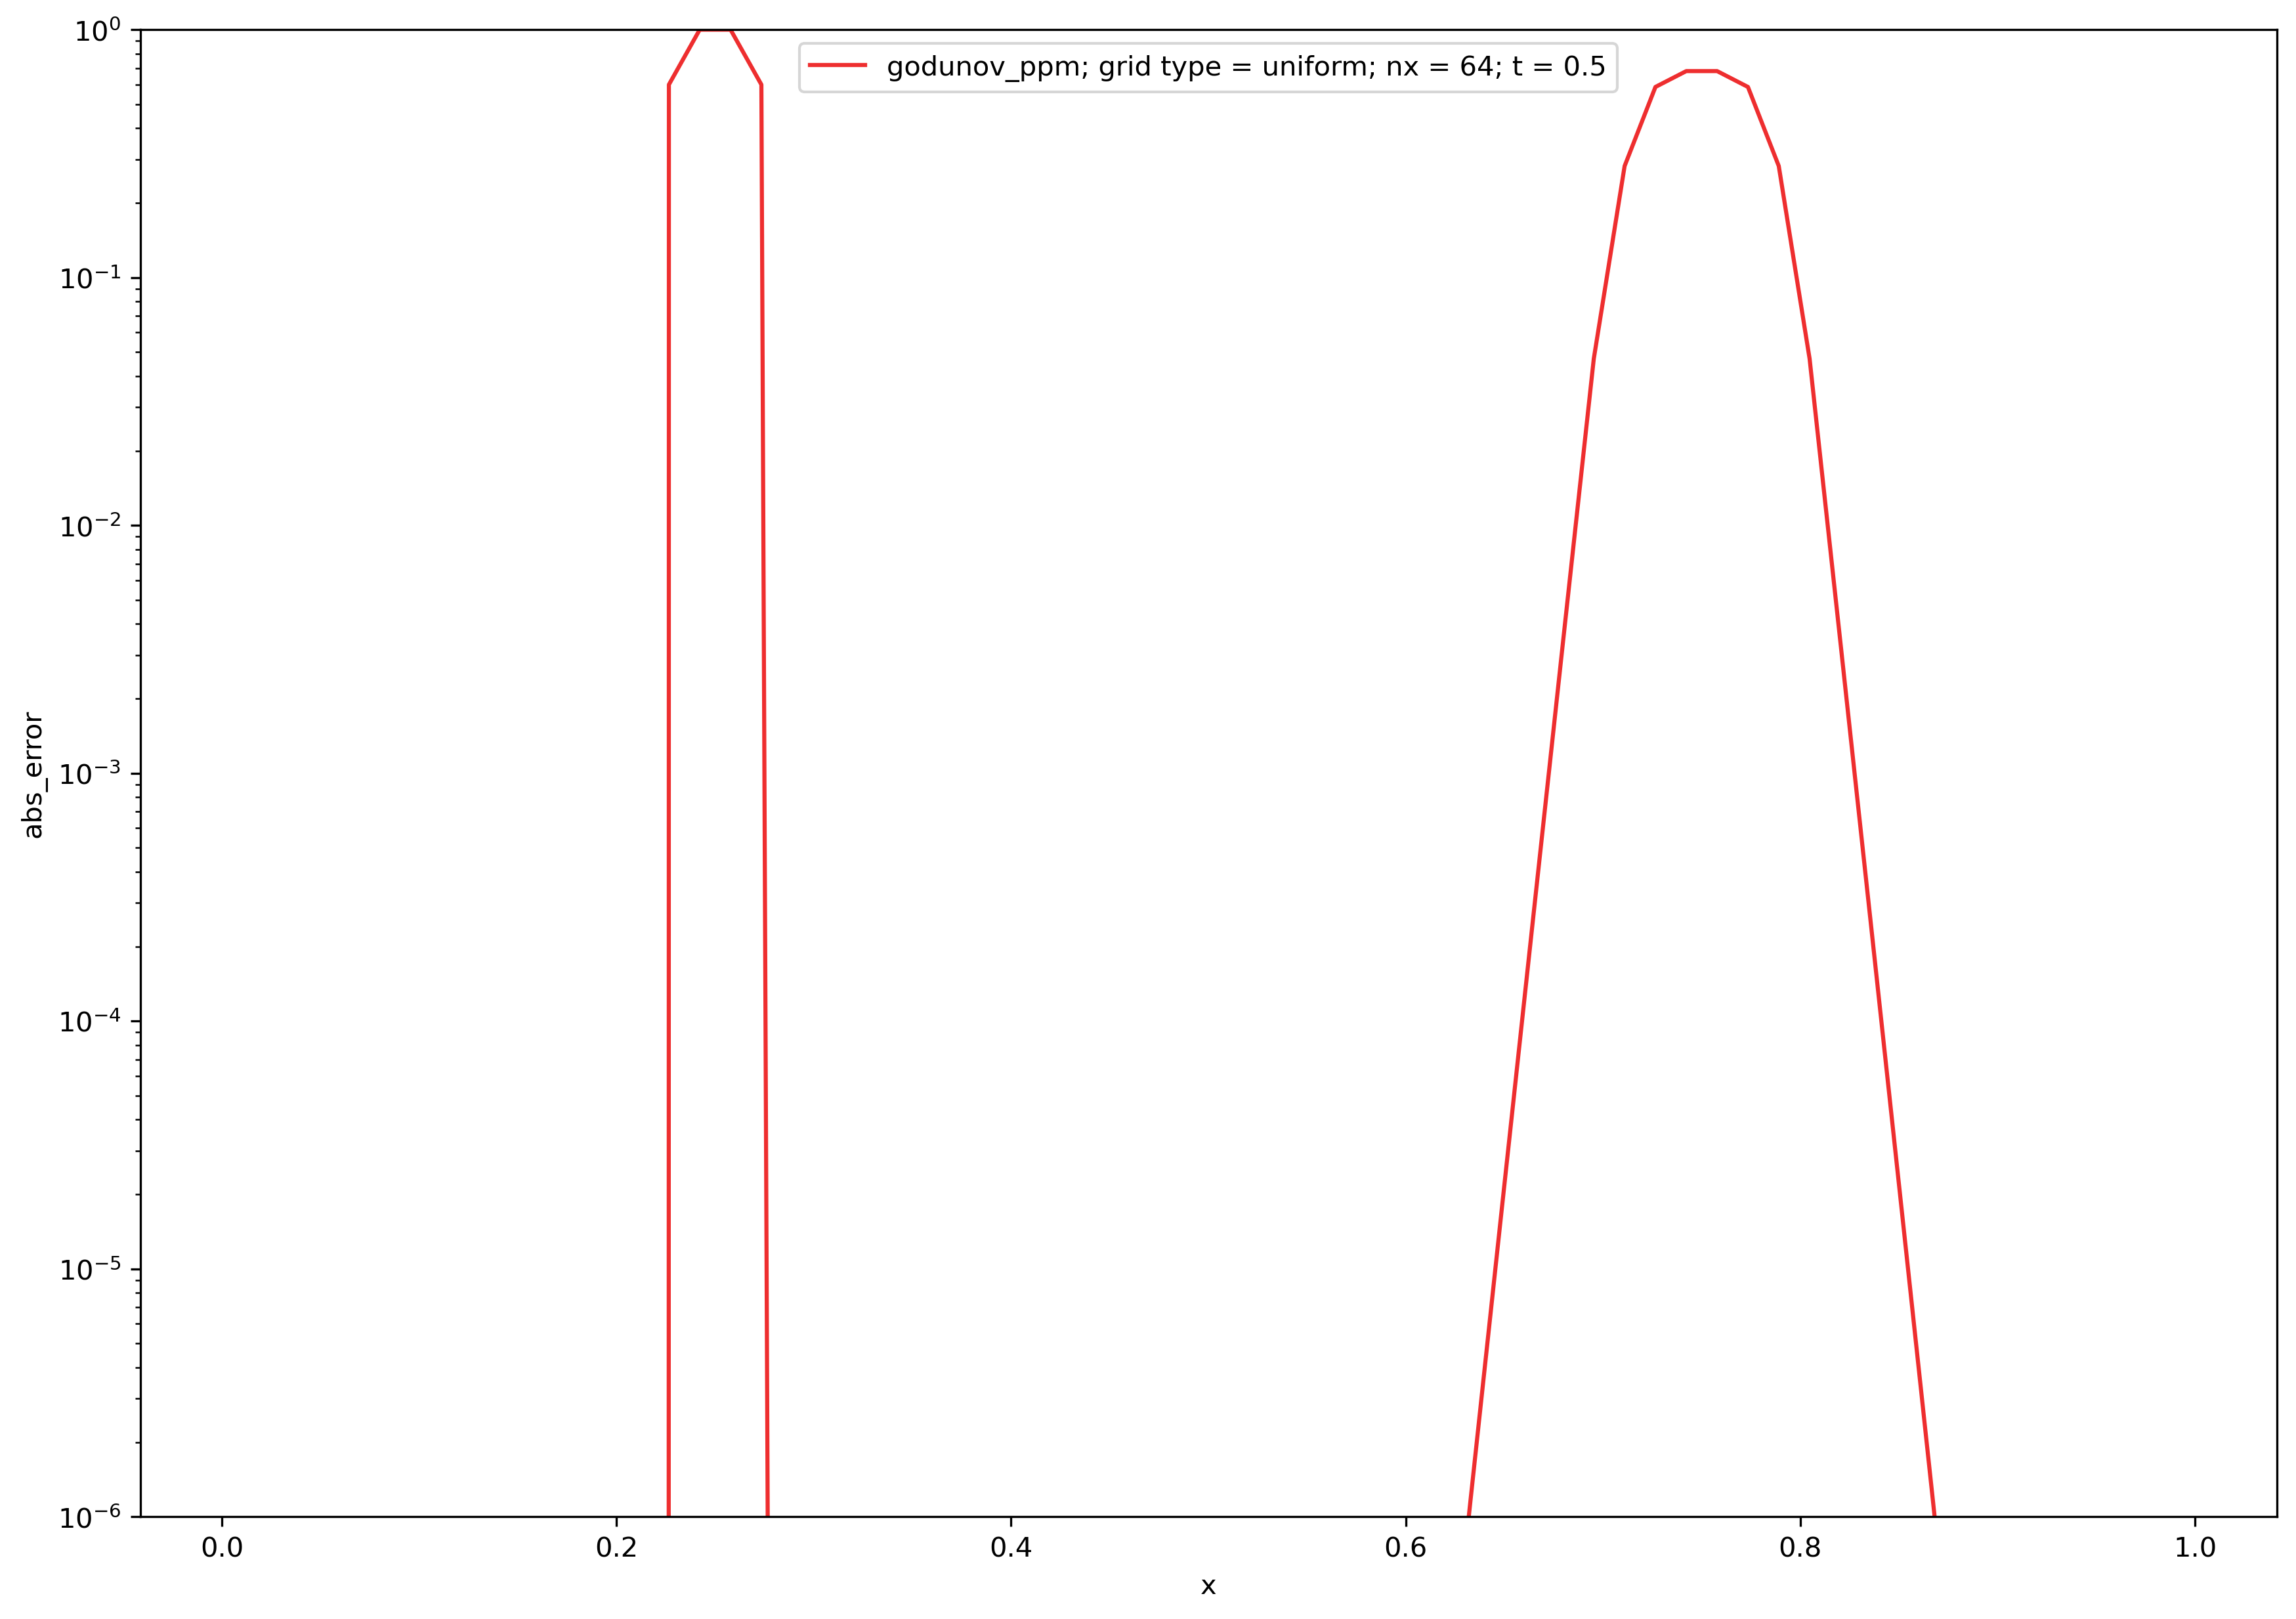

In [159]:
ax3.set_xlabel('x')
ax3.set_ylabel('abs_error')
ax3.set_title('')
ax3.legend()
ax3.set_yscale('log')
ax3.set_ylim([1e-6,1])
fig3